# **PREDICCIÓN DE INGRESOS USANDO ENAHO**

Autor: Mauricio Elias Vallejos Garcia

Correo: mauricio.vallejos@pucp.edu.pe


### PARTE I: Trabajo preliminar

In [1]:
### Librerias con las que vamos a trabajar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from xgboost import XGBClassifier
from xgboost import XGBRegressor

from numpy import absolute
from pandas import read_csv

from sklearn import metrics
from sklearn import linear_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score, roc_auc_score,accuracy_score, precision_score, recall_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import pointbiserialr, spearmanr
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from google.colab import drive

import warnings 
warnings.filterwarnings("ignore")

In [2]:
# Definimos el directorio para trabajar
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/MyDrive/PUCP - ECONOMÍA/CICLO 2022-1/PROGRAMACIÓN EN FINANZAS/final'

/content/drive/MyDrive/PUCP - ECONOMÍA/CICLO 2022-1/PROGRAMACIÓN EN FINANZAS/final


In [4]:
df = pd.read_csv("base_exfinal.csv")

In [5]:
# Creamos una función para realizar la distribución de nuestros gráficos
def dis_data(Rfunction, Bfunction, Rname, Bname, title):
    plt.figure(figsize=(10,6))
    ax1 = sns.distplot(Rfunction, hist = False, color = 'r', label = Rname)
    ax1 = sns.distplot(Bfunction, hist = False, color = 'b', label = Bname)
    plt.title(title)
    plt.show()
    plt.close()

In [6]:
df.head()

,Unnamed: 0,index,AÑO_x,MES_x,CONGLOME,VIVIENDA,HOGAR,CODPERSO,UBIGEO,DOMINIO_x,...,I41811,I41812,I41813,I41814,I41815,I41816,I41817,BLIBRE22,FACTOR_y,ingreso_mensualizado
0,0,14,2022,1,5030,59,11,5,10201,7,...,,7,,,,,,,703.797310,1000.0
1,1,15,2022,1,5030,59,11,7,10201,7,...,,2,,,,,,,628.929411,480.0
2,2,38,2022,1,5138,25,11,3,10513,4,...,,2,,,,,,,362.174060,600.0
3,3,55,2022,1,5138,120,11,3,10513,4,...,,,,,,,,,362.174060,300.0
4,4,56,2022,1,5138,120,11,4,10513,4,...,,,,,,,,,362.174060,480.0


### PARTE II: A continuación, crearemos un código para identificar todas las posibles variables candidatas de la base para ser predictoras del ingreso. Para ello calculamos la correlación (o el estadístico correspondinete) entre la variable y el logaritmo del ingreso. Además, presentaremos en una tabla las 10 variables con mayor correlación así como los gráficos que muestren el sentido que económico de las variables.



In [7]:
df['ln_ingreso'] = np.log(df['ingreso_mensualizado'])

In [8]:
df['ln_ingreso'].describe()

count    5080.000000
mean        6.963254
std         0.921588
min         2.302585
25%         6.579251
50%         7.090077
75%         7.520224
max         9.903488
Name: ln_ingreso, dtype: float64

In [9]:
# Reemplazamos los missings
df=df.replace(r'^\s*$', np.nan, regex=True)
df

,Unnamed: 0,index,AÑO_x,MES_x,CONGLOME,VIVIENDA,HOGAR,CODPERSO,UBIGEO,DOMINIO_x,...,I41812,I41813,I41814,I41815,I41816,I41817,BLIBRE22,FACTOR_y,ingreso_mensualizado,ln_ingreso
0,0,14,2022,1,5030,59,11,5,10201,7,...,7,NaN,NaN,NaN,NaN,NaN,NaN,703.797310,1000.0,6.907755
1,1,15,2022,1,5030,59,11,7,10201,7,...,2,NaN,NaN,NaN,NaN,NaN,NaN,628.929411,480.0,6.173786
2,2,38,2022,1,5138,25,11,3,10513,4,...,2,NaN,NaN,NaN,NaN,NaN,NaN,362.174060,600.0,6.396930
3,3,55,2022,1,5138,120,11,3,10513,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,362.174060,300.0,5.703782
4,4,56,2022,1,5138,120,11,4,10513,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,362.174060,480.0,6.173786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5075,5075,20387,2022,3,20346,122,11,1,250106,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,389.360728,40.0,3.688879
5076,5076,20393,2022,3,20346,124,11,3,250106,7,...,2,NaN,NaN,NaN,NaN,NaN,NaN,339.083762,300.0,5.703782
5077,5077,20397,2022,3,20349,7,11,1,250202,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,389.360728,600.0,6.396930
5078,5078,20407,2022,3,20355,180,11,1,250201,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,389.360728,930.0,6.835185


In [10]:
# Corregimos los outliers
def CORREGIR_OUTLIER(x, p_lower,p_upper):
    if (x<p_lower):
        return p_lower
    elif (x>p_upper):
        return p_upper
    else:
        return x

p_1 = np.percentile(df["P301A"], 0.5)
p_99 = np.percentile(df["P301A"],99)
print("el percentile p1 es {0} y el p99 es {1}".format(p_1,p_99))
df["P301A"] = df["P301A"].apply(lambda x: CORREGIR_OUTLIER(x,p_1,p_99))

el percentile p1 es 1.0 y el p99 es 11.0


In [11]:
# Observamos la correlación
df.corr('pearson')['ln_ingreso']

Unnamed: 0              0.034323
index                   0.034389
AÑO_x                        NaN
MES_x                   0.026452
CONGLOME                0.016962
                          ...   
P414$17                 0.038408
TICUEST01A                   NaN
FACTOR_y                0.152189
ingreso_mensualizado    0.709580
ln_ingreso              1.000000
Name: ln_ingreso, Length: 245, dtype: float64

In [12]:
# Creamos un código para ordenar la correlación
df_corr=pd.DataFrame(df.corr('pearson')['ln_ingreso'])
df_corr['ln_ingreso'] = np.abs(df_corr['ln_ingreso'])
df_corr=df_corr.sort_values('ln_ingreso', ascending=False)
df_corr=df_corr.dropna()

In [13]:
df_corr

,ln_ingreso
ln_ingreso,1.000000
ingreso_mensualizado,0.709580
OCUPINF,0.549913
P558A5,0.549809
P5441A,0.499288
...,...
P5574A,0.001012
P55612A,0.000845
P5573A,0.000628
P4024,0.000303


 Por lo tanto nos quedamos con las 10 primeras variables:

 - OCUPINF (Situación de informalidad (ocup.principal)), 
 - P558A5 (¿El Sistema de pensiones al cual Ud. está afiliado es:),
 - P5441A (En los últimos 12 meses, de ... a ... ¿Recibió algún dinero por: Gratificación de navidad?), 
 - P5442A (En los últimos 12 meses, de ... a ... ¿Recibió algún dinero por: Gratificación de fiestas patrias?)), 
 - P505 (¿Cuál es la ocupación principal que desempeño? (revisión CNO-2015)), 
 - P4191 (El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿EsSalud?)), 
 - P505R4 (¿Cuál es la ocupación principal que desempeño? (revisión CNO-2015)), 
 - P4195 (El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Seguro integral de salud (SIS)?) , 
 - P558A1 (¿El Sistema de pensiones al cual Ud. está afiliado es: Sistema privado de pensiones ( AFP)?)), 
 - P301A (¿Cuál es el último año o grado de estudios y nivel que aprobó? - Nivel 1).


** Sin embargo, algunas variables pueden llegar a ser redundantes entre sí, por lo que se seleccionaran solo las 10 primeras que no incurran en este problema. Tampoco consideramos transferencias de dinero como bonos.**

 - OCUPINF (Situación de informalidad (ocup.principal)), 
 - P4195 (El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Seguro integral de salud (SIS)?) , 
 - P558A1 (¿El Sistema de pensiones al cual Ud. está afiliado es: Sistema privado de pensiones ( AFP)?)), 
 - P301A (¿Cuál es el último año o grado de estudios y nivel que aprobó? - Nivel 1).
 - P507 (Ud. se desempeño en su ocupación principal o negocio como:)
 - ESTRATO_x.1 (ESTRATO_x.1)
 - P513A1 ¿Cuánto tiempo trabaja Ud., en esta Ocupación Principal? - Años)
 - P208A (¿Qúe edad tiene en años cumplidos? (En años) )
 - P558D2_1 (El lugar donde desempeña su ocupación principal (trabajo), ¿Está ubicado:)
 - P513T (¿Cuántas horas trabajó la semana pasada, en su ocupación principal, el día: Total )


** Además tenemos algunas variables extras seleccionadas en caso de tener alta correlación entre las seleccionadas y considerar el posible problema de multicolinealidad**

 - P522A (La semana pasada ¿Ha realizado su trabajo?  Presencial Virtual)
 - P407I (¿Le realizaron alguna prueba para descartar el COVID-19? )
 - P514 (¿Además de su ocupación principal la semana pasada, ¿Tuvo Ud. otro trabajo para obtener ingresos?)
 - P209_y (¿Cuál es su estado civil o conyugal?)
 - P558C (Por sus antepasados y de acuerdo a sus costumbres, ¿ud. se considera:)
 - P207 (Sexo)



In [14]:
variables=df[["ln_ingreso", "OCUPINF", "P558A5", "P5441A", "P5442A", "P505", "P4191", "P505R4", "P4195","P558A1", "P301A", "P507", "ESTRATO_x.1", "P513A1", "P208A_y", "P558D2_1", "P513T", "P522A", "P407I", "P514", "P209_y", "P558C", "P207_y"]]

Text(0.5, 1.0, 'Correlation Heatmap')

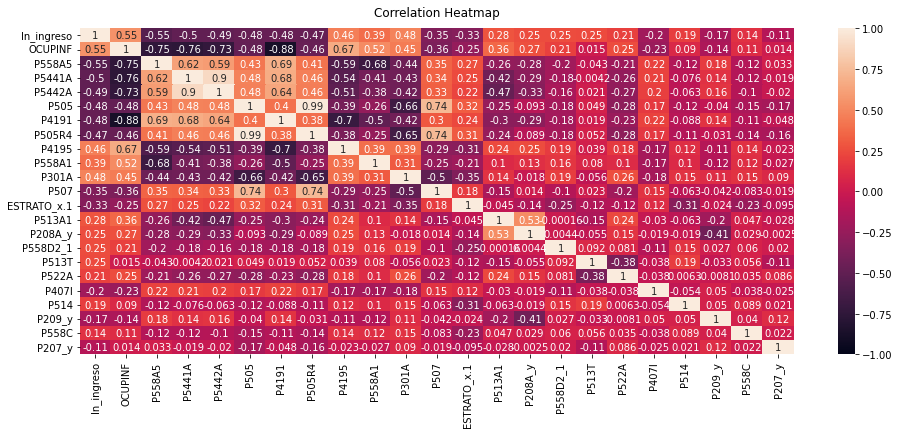

In [15]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(variables.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

De dicha observación seleccionamos variables que tengan sentido económico y además sean relevantes una a una

In [16]:
variables_finales = df[["ln_ingreso", "OCUPINF", "P522A", "P558A1","P301A", "P513T", "P507", "ESTRATO_x","P513A1", "P208A_y.1","P558D2_1"]]

Text(0.5, 1.0, 'Mapa de calor de correlación')

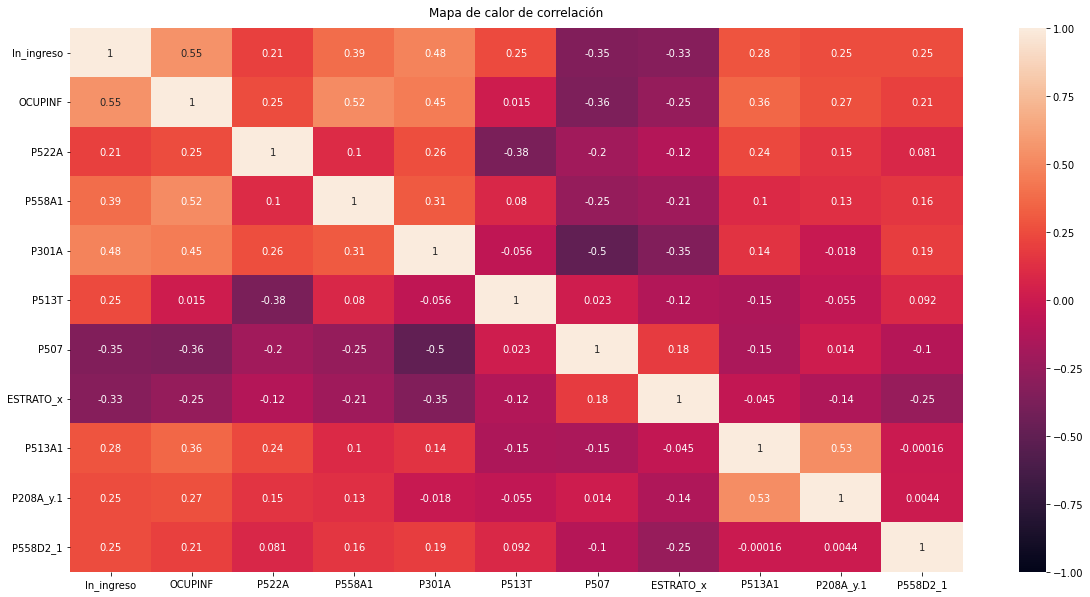

In [17]:
 plt.figure(figsize=(20, 10))

 heatmap = sns.heatmap(variables_finales.corr(), vmin=-1, vmax=1, annot=True) 
 heatmap.set_title('Mapa de calor de correlación', fontdict={'fontsize':12}, pad=12)

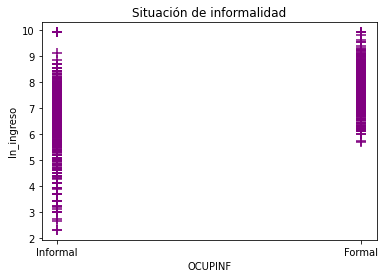

In [18]:
#Gráficas de Correlación 
variables['OCUPINF'].replace([1,2],['Informal','Formal'],inplace=True)
variables.plot.scatter('OCUPINF','ln_ingreso', marker ="+", s = 100, title="Situación de informalidad", color="purple") 

plt.show()

En este se aprecia que los trabajadores formales son los que reciben una mayor remuneración en comparación con los trabajadores del sector informal.

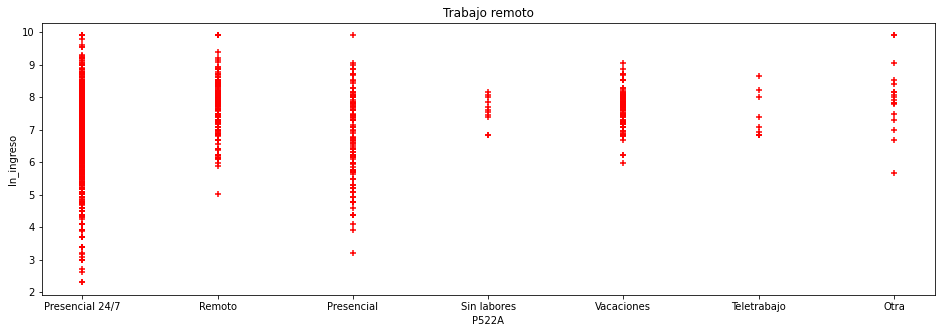

In [19]:
variables['P522A'].replace([1,2,3,4,5,6,7],['Presencial 24/7','Presencial','Remoto','Teletrabajo','Vacaciones','Otra','Sin labores'],inplace=True)
variables.plot.scatter('P522A','ln_ingreso', marker ="+", s = 30, title="Trabajo remoto", color="red", figsize=(16, 5)) # En 


Para el caso de esta variable, se aprecia que existe una mayor proporción por aquellos que hacen trabajo presencial total. En el caso de ellos, la distribución de los salarios se muestra pareja a lo largo de los valores de la variable. Sin embargo, es rescatable apreciar que solo hacen trabajo remoto aquellos que se encuentran por encima del valor 5 en la escala del 2 al 10. De esta manera, podríamos inferior que solo hacen trabajo remoto aquellos que que se encuentran sobre un umbral de ingresos.

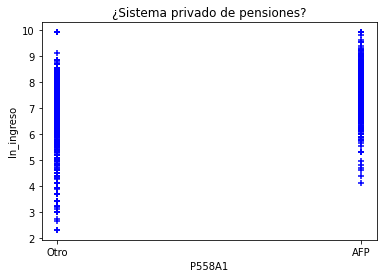

In [20]:
variables['P558A1'].replace([0,1],['Otro','AFP'],inplace=True)
variables.plot.scatter('P558A1','ln_ingreso', marker ="+", s = 30, title="¿Sistema privado de pensiones?", color="blue") #

plt.show()

Los que se encuentran en el sistema de pensiones privado tienen mayores ingresos que aquellos que ocupan otro sistema de pensiones.

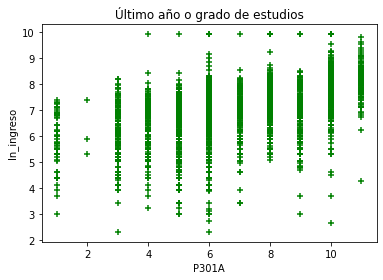

In [21]:
variables.plot.scatter('P301A','ln_ingreso', marker ="+", s = 30, title="Último año o grado de estudios", color="green") #

plt.show()

En este caso, se observa que progresivamente aumentan los salarios conforme aumentan los años de educación.

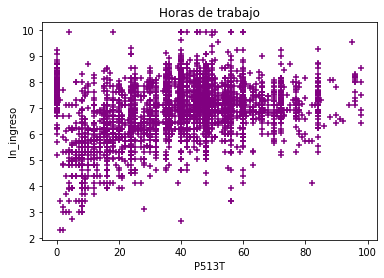

In [22]:
variables_finales.plot.scatter('P513T','ln_ingreso', marker ="+", s = 30, title="Horas de trabajo", color="purple") #

plt.show()

Aquellos que realizán mayor cantidad d ehoras de trabajo reciben un mayor ingreso. Tiene sentido económico esta interpretación. Luego están aquellos que no realizan horas de trabajo, pero aun así reciben ingreso. Esto se podría explicar porque reciben algún tipo de pensión.

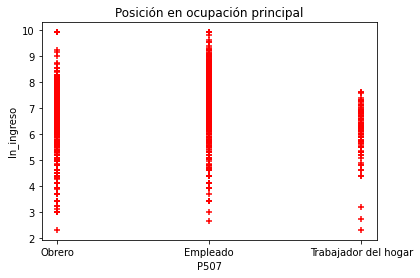

In [23]:
variables['P507'].replace([1,2,3,4,5,6,7],['Empleador','Independiente','Empleado','Obrero','Familiar no remunerado','Trabajador del hogar','Otro'],inplace=True)

variables.plot.scatter('P507','ln_ingreso', marker ="+", s = 30, title="Posición en ocupación principal", color="red") #

plt.show()

Los empleados y obreros se distribuyen a lo largo de los diferentes posibles valores par alos ingresos. Sin embargo, los trabajadores dle hogar solo se encuentra por debajo de cierto umbral.

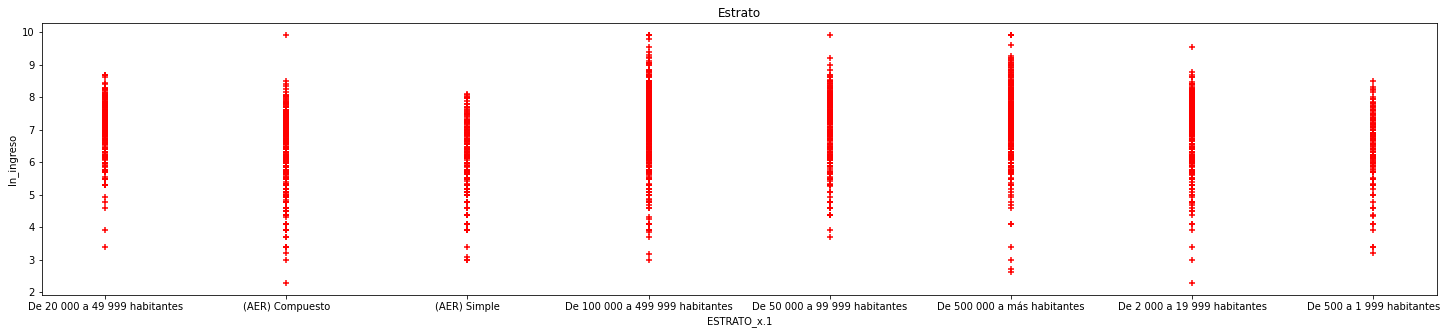

In [24]:
variables['ESTRATO_x.1'].replace([1,2,3,4,5,6,7,8],['De 500 000 a más habitantes','De 100 000 a 499 999 habitantes','De 50 000 a 99 999 habitantes','De 20 000 a 49 999 habitantes','De 2 000 a 19 999 habitantes','De 500 a 1 999 habitantes','(AER) Compuesto','(AER) Simple'],inplace=True)

variables.plot.scatter('ESTRATO_x.1','ln_ingreso', marker ="+", s = 30, title="Estrato", color="red", figsize=(25, 5))
plt.show()

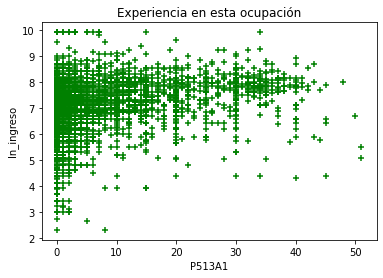

In [25]:
variables_finales.plot.scatter('P513A1','ln_ingreso', marker ="+", s = 30, title="Experiencia en esta ocupación", color="green") #

plt.show()

A mayor experiencia, mayor salario. Sin embargo, también hay recién ingresantes al trabajo que pudieron haber tenido uno similar previo y es por ello que a pesar de solo tener 1 año de experiencia reciben salarios muy altos.

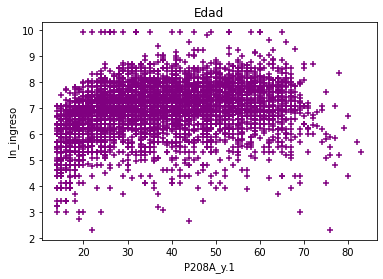

In [26]:
variables_finales.plot.scatter('P208A_y.1','ln_ingreso', marker ="+", s = 30, title="Edad", color="purple") #

plt.show()

Se puede observar que se forma una parábola concava. Esto se debe a que conforme aumenta la edad también aumentan los salarios pero solo hasta cierto momento. Luego se espera que los salarios comiencen a decaer así como en el gráfico.

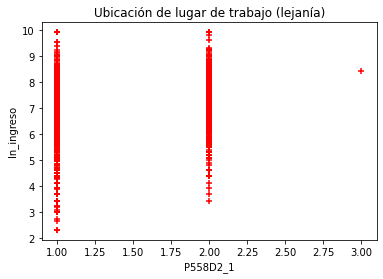

In [27]:
variables_finales.plot.scatter('P558D2_1','ln_ingreso', marker ="+", s = 30, title="Ubicación de lugar de trabajo (lejanía)", color="red") #

plt.show()

### PARTE III: A continuación, crearemos modelos para predecir el ingreso. Usaremos el 70% de la base para modelar y presentaremos los estadísticos resultados del modelo.


### 1. XGBoost 


In [28]:
# Seleccionamos los sets de variales
X = df[["OCUPINF", "P522A", "P558A1","P301A", "P513T", "P507", "ESTRATO_x","P513A1", "P208A_y.1","P558D2_1"]]
y = df['ln_ingreso']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=3/10,random_state=0)

In [29]:
# Definimos el modelo
model_1 = XGBRegressor()
# definir el método de evaluación del modelo
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# Evaluar el modelo
scores = cross_val_score(model_1, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# Forzamos que los resultados del score sean positivos
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )


Mean MAE: 0.412 (0.013)


In [31]:
model_1.fit(X_train, y_train)

[23:18:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [32]:
xgboost = model_1.predict(X_test)

In [33]:
print ('Mean Absolute Error:', metrics.mean_absolute_error(y_test, xgboost))
print ('Mean Squared Error:', metrics.mean_squared_error(y_test, xgboost))
print ('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, xgboost)))
print ("R2-score: %.2f" % r2_score(xgboost , y_test))

Mean Absolute Error: 0.4140357837257542
Mean Squared Error: 0.33349648910049245
Root Mean Squared Error: 0.5774915489429195
R2-score: 0.33


### 2.Regresión lineal


In [34]:
# Seleccionamos los sets de variales
X = df[["OCUPINF", "P522A", "P558A1","P301A", "P513T", "P507", "ESTRATO_x","P513A1", "P208A_y.1","P558D2_1"]]
y = df['ln_ingreso']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=3/10,random_state=0)

In [35]:
# Usaremos la regresión lineal aquí ya que el salario es una variable continua. Con todos los datos, vemos que este es un caso de aprendizaje de Regresión Supervisada. Estableceremos el modelo de referencia aplicando la regresión lineal a feat_train, sal_train.
from sklearn.linear_model import LinearRegression
#Crear objeto de regresión lineal y ajustar el modelo
lm = LinearRegression()
lm.fit(X_train,y_train)
lm

LinearRegression()

In [36]:
#Ver el coeficiente del objeto de regresión lineal
print(lm.intercept_)
print(lm.coef_)

4.632466743614334
[ 0.45628733  0.1261892   0.15304804  0.10650889  0.01499297 -0.07781715
 -0.02440324  0.01036251  0.00702073  0.1413726 ]


In [37]:
#predecir el salario usando datos de entrenamiento
yhat = lm.predict(X_train)

#Ver las primeras cinco predicciones -
print ('First five predictions:' , yhat[0:5])

# El error cuadrático medio (MSE) se evaluará ahora junto con la precisión y el cuadrado r para evaluar el rendimiento del modelo de referencia y determinar si los modelos posteriores mejoran con respecto al modelo de referencia establecido.


First five predictions: [7.22177203 8.03796935 7.26493872 6.8613106  7.00552905]


In [38]:
#Ver MSE - 
print ('Mean Squared Error of our prediction model', mean_squared_error(y_train, yhat))

print ('R-squared of test data-', lm.score(X_test, y_test))

Mean Squared Error of our prediction model 0.41893333603646876
R-squared of test data- 0.4994857202150439


### 3. Regresión lineal con características polinómicas: Ahora aplicaremos características polinómicas al modelo de regresión lineal ya construido y veremos si MSE se reduce y mejora la predcción.

In [39]:
#forma y características -

print ('Number of training samples-', X_train.shape, '\n with the features-', X_train.columns)
print ('Number of testing samples-', X_test.shape, '\n with the features-', X_test.columns)
print ('Number of training salaries-', y_train.shape)
print ('Number of testing salaries-', y_test.shape )

Number of training samples- (3556, 10) 
 with the features- Index(['OCUPINF', 'P522A', 'P558A1', 'P301A', 'P513T', 'P507', 'ESTRATO_x',
       'P513A1', 'P208A_y.1', 'P558D2_1'],
      dtype='object')
Number of testing samples- (1524, 10) 
 with the features- Index(['OCUPINF', 'P522A', 'P558A1', 'P301A', 'P513T', 'P507', 'ESTRATO_x',
       'P513A1', 'P208A_y.1', 'P558D2_1'],
      dtype='object')
Number of training salaries- (3556,)
Number of testing salaries- (1524,)


In [40]:
#Ajusta y transforma las variables con polinomio de segundo orden
pr = PolynomialFeatures(2)
X_train_pr = pr.fit_transform(X_train)
X_test_pr = pr.fit_transform(X_test)
pr

PolynomialFeatures()

In [41]:
#Crear un nuevo modelo usando Transformación Polinomial
poly = LinearRegression()
poly.fit(X_train_pr, y_train)

LinearRegression()

In [42]:
#hacer predicciones y ver las primeras cinco predicciones en los datos del tren - 
yhat_pr = poly.predict(X_train_pr)
print ('First five predictions(train data)-', yhat_pr[0:5])

First five predictions(train data)- [7.27249129 7.55848341 7.05566805 7.30362816 7.22362333]


In [43]:
#Compare los primeros cinco valores predichos con los valores reales -
print ('Predicted Values(train)-', yhat_pr[0:5])
print ('Actual Values(train)-', y_train[0:5].values)

Predicted Values(train)- [7.27249129 7.55848341 7.05566805 7.30362816 7.22362333]
Actual Values(train)- [7.60090246 8.19312372 6.68461173 7.78322402 6.2146081 ]


In [45]:
#hacer predicciones y ver las primeras cinco predicciones en datos de prueba -
yhat_prtest = poly.predict(X_test_pr)
print ('First five predictions(test data)-', yhat_prtest[0:5])

First five predictions(test data)- [6.41523346 7.95441746 6.60301648 6.91834839 6.83619831]


In [46]:
#Compare los valores pronosticados de los datos de prueba y los valores reales de los datos de prueba -
print ('Predicted values(test)-', yhat_prtest[0:5])
print ('Actual values(test)-', y_test[0:5].values)

Predicted values(test)- [6.41523346 7.95441746 6.60301648 6.91834839 6.83619831]
Actual values(test)- [6.75693239 7.82404601 6.46146818 7.17011954 6.68461173]


In [47]:
#imprimir valores R-cuadrados de datos de entrenamiento y prueba -
print ('R-squared of training data-', poly.score(X_train_pr, y_train))
print ('R-squared of testing data-', poly.score(X_test_pr, y_test))

R-squared of training data- 0.5942650229430411
R-squared of testing data- 0.5710450920126687


### 4.Regresión RIDGE: Tenemos una definitiva mejora y por lo tanto ahora procederemos a tratar de mejor aun más el modelo. Para ello, comprobaremos si la aplicación de la regresión de Ridge reduce el MSE

In [48]:
from sklearn.linear_model import Ridge

# Modelo
RidgeModel = Ridge(alpha = 1.0)
RidgeModel.fit(X_train_pr, y_train)

Ridge()

In [51]:
#predict valores de datos de entrenamiento y datos de prueba
yhat_Ridge_train = RidgeModel.predict(X_train_pr)
yhat_Ridge_test = RidgeModel.predict(X_test_pr)

In [52]:
#compara los valores reales y predichos de los datos de entrenamiento
print ('Predicted Values(train)-', yhat_Ridge_train[0:5])
print ('Actual Values(train)-', X_train[0:5].values)

Predicted Values(train)- [7.26916227 7.55602023 7.04984739 7.29846529 7.2162493 ]
Actual Values(train)- [[ 1.  1.  0. 11. 40.  3.  1.  0. 30.  2.]
 [ 2.  1.  0.  6. 96.  3.  2. 15. 39.  1.]
 [ 1.  3.  0.  9. 44.  3.  1.  0. 22.  2.]
 [ 1.  1.  1.  6. 42.  4.  2.  0. 43.  2.]
 [ 1.  1.  0.  8. 42.  4.  2.  0. 55.  2.]]


In [53]:
#compare los valores reales y predichos de los datos de prueba
print ('Predicted Values(test)-', yhat_Ridge_test[0:5])
print ('Actual Values(test)-', y_test[0:5].values)

Predicted Values(test)- [6.42934483 7.95811169 6.60052601 6.91137651 6.82859448]
Actual Values(test)- [6.75693239 7.82404601 6.46146818 7.17011954 6.68461173]


In [54]:
#R-cuadrado de datos de entrenamiento y prueba -
print ('R-squared values(train)-', RidgeModel.score(X_train_pr, y_train))
print ('R-squared values(test)-', RidgeModel.score(X_test_pr, y_test))

R-squared values(train)- 0.5942038946326104
R-squared values(test)- 0.5709890254549947


In [55]:
#MSE de datos de entrenamiento y prueba -
print ('MSE of training data-', mean_squared_error(y_train, yhat_Ridge_train))
print ('MSE of testing data-', mean_squared_error(y_test, yhat_Ridge_test))

MSE of training data- 0.3443086501262627
MSE of testing data- 0.36490858681425714


### 5.GRID SEARCH: En este caso, no observamos mejoras significativas. Ahora usemos Grid Search para asegurarnos de que se usen los hiperparámetros correctos:

In [56]:
#define el hiperparámetro 
parameters1 = [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

In [57]:
#Crear un nuevo Ridge regression
RM = Ridge()

In [58]:
#create a gridsearch object and pass RM, parameters1 to it. 
from sklearn.model_selection import GridSearchCV

Grid = GridSearchCV(RM, parameters1, cv = 5)

In [59]:
#ajustar el modelo de búsqueda de cuadrícula a los datos de entrenamiento- 
Grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    100000]}])

In [60]:
#asignar mejor estimador -
bestRM = Grid.best_estimator_
bestRM

Ridge(alpha=1)

In [61]:
#Modelo de prueba usando datos de prueba -
bestRM.score(X_test, y_test)

0.49949140781758994

### 6. RANDOM FOREST: Sin mejora usando alfa = 1. Por lo tanto, A continuación, intentemos usar Random Forest y Fit a Randomm Forest con random_state = 1 para mantener la coherencia.

In [62]:
#Creamos un random forest object - 
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor(n_estimators=100, random_state=10)
#fit a Random Forest model on training data - 
RF.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

In [63]:
#hacer predicciones sobre datos de prueba e imprimir los primeros cinco:
yhat_RF_test = RF.predict(X_test)
print ('First five predictions-', yhat_RF_test[0:5])

First five predictions- [6.65633536 7.7972137  6.13384859 6.91752924 6.97201049]


In [64]:
from sklearn import metrics

print ('MSE of test data-', mean_squared_error(y_test, yhat_RF_test))
print ('R-squared of test data-', RF.score(X_test, y_test))

MSE of test data- 0.3694010021009695
R-squared of test data- 0.5657074411627775


#### La regresión lineal con transformación polinomial de segundo orden dio las mejores predicciones con un MSE de 0.364 y una precisión del 57 %. Esto cumple con el objetivo de reducir el MSE a menos de 360. Sin embargo, como segunda opción a seguir tendríamos el modelo XGBOOST. En la siguiente sección se hará el análisis correspondiente.

### PARTE IV: A continuación, usaremos el mejor modelo encontrado y aplicaremos los métodos de validación.


### En este caso para cada modelo hemos presentado un análisis del poder predictivo y el MSE. Además hemos podido observar la distribución de las predcciones.

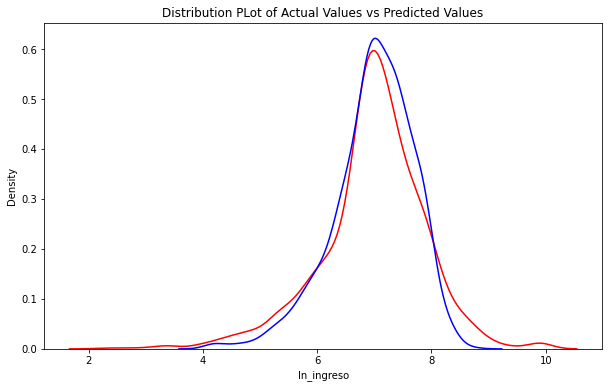

Mean Absolute Error: 0.4140357837257542
Mean Squared Error: 0.33349648910049245
Root Mean Squared Error: 0.5774915489429195
R2-score: 0.33


In [65]:
# XGBoost
Title = 'Distribution PLot of Actual Values vs Predicted Values'
dis_data(y_test, xgboost, 'Actual Values(train)', 'Predicted Values(train)', Title)

print ('Mean Absolute Error:', metrics.mean_absolute_error(y_test, xgboost))
print ('Mean Squared Error:', metrics.mean_squared_error(y_test, xgboost))
print ('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, xgboost)))
print ("R2-score: %.2f" % r2_score(xgboost , y_test))

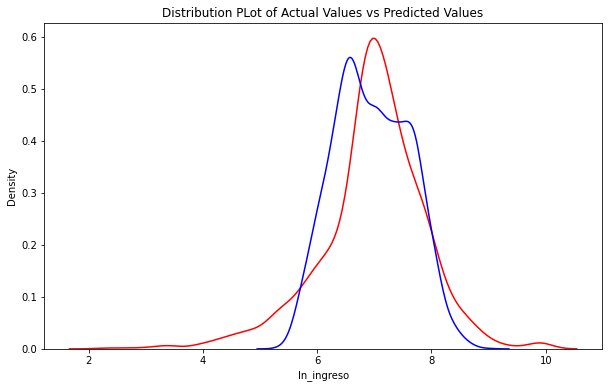

R-squared of test data- 0.4994857202150439
Mean Squared Error of our prediction model 0.41893333603646876
5-Cross Validation accuracy 0.5013821345425389 0.023046970548736147


In [66]:
# Regresión lineal

Title = 'Distribution PLot of Actual Values vs Predicted Values'
dis_data(y_test, yhat, 'Actual Values(train data)', 'Predicted Values(train data)', Title)
print ('R-squared of test data-', lm.score(X_test, y_test))
print ('Mean Squared Error of our prediction model', mean_squared_error(y_train, yhat))

# precisión del modelo de referencia utilizando el método de validación de 5 cruces -
score = cross_val_score(lm, X_train, y_train, cv = 5)
print ('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))

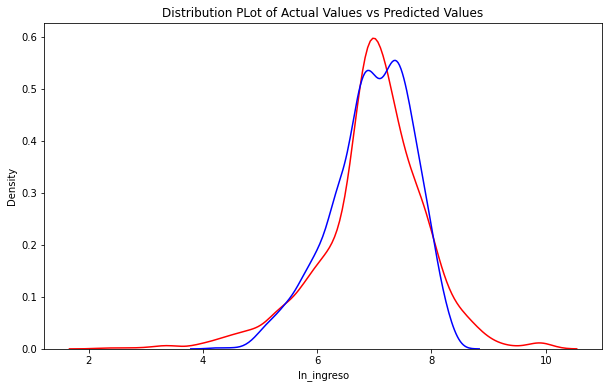

R-squared of training data- 0.5942650229430411
R-squared of testing data- 0.5710450920126687


In [67]:
# Regresión lineal con características polinómicas
Title = 'Distribution PLot of Actual Values vs Predicted Values'
dis_data(y_test, yhat_pr, 'Actual Values(train)', 'Predicted Values(train)', Title)
print ('R-squared of training data-', poly.score(X_train_pr, y_train))
print ('R-squared of testing data-', poly.score(X_test_pr, y_test))

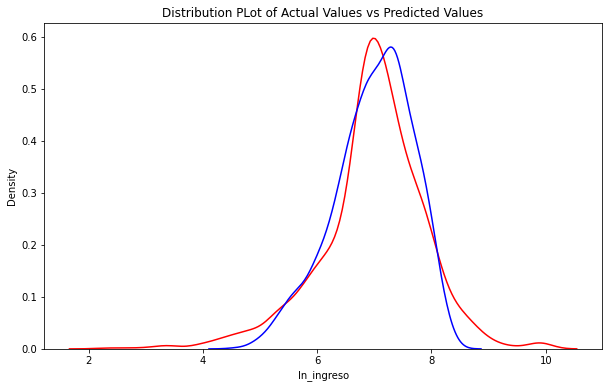

R-squared values(train)- 0.5942038946326104
R-squared values(test)- 0.5709890254549947
MSE of training data- 0.3443086501262627
MSE of testing data- 0.36490858681425714


In [68]:
# Regresión Ridge
Title = 'Distribution PLot of Actual Values vs Predicted Values'
dis_data(y_test, yhat_Ridge_test, 'Actual Values(train)', 'Predicted Values(train)', Title)
#R-squared of training and testing data - 
print ('R-squared values(train)-', RidgeModel.score(X_train_pr, y_train))
print ('R-squared values(test)-', RidgeModel.score(X_test_pr, y_test))
#MSE of training and testing data - 
print ('MSE of training data-', mean_squared_error(y_train, yhat_Ridge_train))
print ('MSE of testing data-', mean_squared_error(y_test, yhat_Ridge_test))

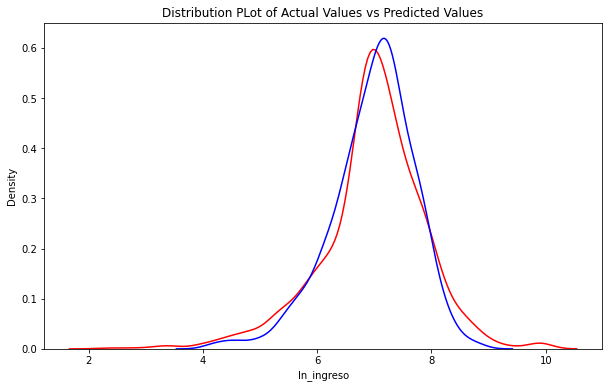

MSE of test data- 0.3694010021009695
R-squared of test data- 0.5657074411627775


In [69]:
# Random Forest
Title = 'Distribution PLot of Actual Values vs Predicted Values'
dis_data(y_test, yhat_RF_test, 'Actual Values(train)', 'Predicted Values(train)', Title)
print ('MSE of test data-', mean_squared_error(y_test, yhat_RF_test))
print ('R-squared of test data-', RF.score(X_test, y_test))

La regresión lineal con transformación polinomial de segundo orden dio las mejores predicciones con un MSE de 0.364 y una precisión del 57 %. Considero que el modelo podría mejorar si probamos otros predictores o si es que la data tuviera más disponibilidad de variables. 



### PARTE V: Finalmente, crearmeos un gráfico de nube de puntos de los valores reales vs los predichos. Además, un histograma de los valores predichos superpuestos a los reales


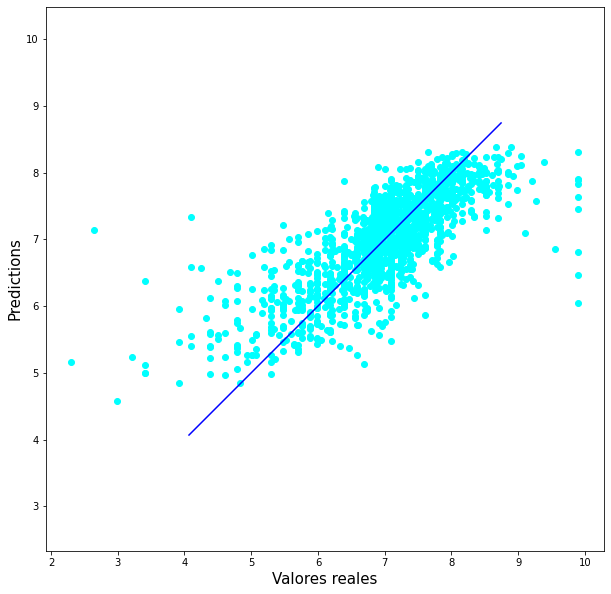

In [70]:
#Debido a que habíamos optado por dos posibles modelos, en este caso usaremos el XGOOST para el gráfico de dispersión

plt.figure(figsize=(10,10))
plt.scatter(y_test, yhat_Ridge_test, color='cyan')



p1 = max(max(xgboost), max(xgboost))
p2 = min(min(xgboost), min(xgboost))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Valores reales', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

- En este caso, se observa que existe una relación positiva entre los valores predichos y los valores que ya se tenían de la base de datos. Ello da buenos indicios sobre el uso del modelo y las variables para este trabajo. De esta manera, comprobamos que finalmente se ha predecido de la mejor manera posible con las variables disponibles
- EN este caso podemos predecir diferentes niveles de ingresos gracias a que tenemos una base de datos con muchas obervaciones. Se espera que aquellas personas con ingresos altas repitan patrones en características como educación, tipo de trabajo, lugar de vivienda, genero y entre otras. De esta manera, los algoritmos agrupan datos de las variables para hacer la mejro predicción posible.


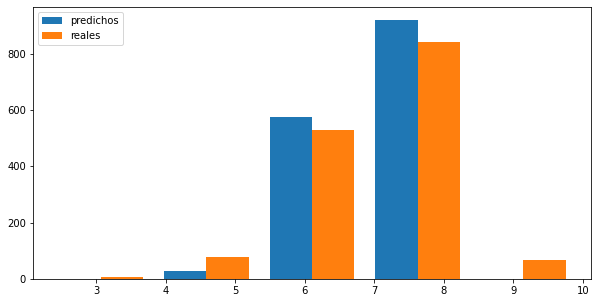

In [71]:
plt.figure(figsize=(10,5))
plt.hist([yhat_Ridge_test,y_test], bins=5, label=['predichos', 'reales'])
plt.legend(loc='upper left')
plt.show()

En este caso podríamos comentar que los valores predichos se encuentran ligeramente inflados en la parte media de la distribución. Sin embargo, para los ingresos muy altos la predicción está subestimada. Esto se puede deber a que no existne muchas observaciones con inbgresos muy altos. Lo mismo ocurre para la parte baja. Sin embargo, en la parte media tenemos la certeza de que la predcción está muy bien alineada.